# 1. 추론 기반 기법과 신경망

### 통계 기반 기법의 문제점

In [1]:
## 통계 기반 기법에서는 주변 단어의 빈도를 기초로 단어를 표현했습니다. 
## 그러나 이 방식은 대규모 말뭉치를 다룰 때 문제가 발생합니다.

## 통계 기반 기법은 말뭉치 전체의 통계(동시발생 행렬, PPMI)를 이용해 단 1회의 처리(SVD 등)만에 단어의 분산 표현을 얻는다.
## 추론 기반 기법에서는, 예로 신경망을 이용하는 경우는 미니배치로 학습하는 것이 일반적이다.
## 신경망이 한 번에 소량(미니배치)의 학습 샘플씩 반복해서 학습하며 가중치를 갱신해 간다.
## 이 말은 말뭉치의 어휘 수가 많아 SVD 등 계산량이 큰 작업을 처리하기 어려운 경우에도 신경망을 학습시킬 수 있다는 뜻이다.

### 추론 기반 기법 개요

In [2]:
## 추론 기반 기법에서는 당연히 '추론'이 주된 작업입니다. 추론이란 주변 단어(맥락)이 주어졌을 때 목적으로 하는 단어를
## 추측하는 작업이다.
## 이러한 추론 문제를 반복해서 풀면서 단어의 출현 패턴을 학습하는 것이다.

##  input(맥락 단어) ---> 모델 ---> output(각 단어의 출현 확률)

## 추론 기반 기법도 통계 기반 기법처럼 분포 가설에 기초한다. 분포 가설이란 '단어의 의미는 주변 단어에 의해 형성된다'는 가설
## 두 기법 모두 분포 가설에 근거하는 '단어의 동시발생 가능성'을 얼마나 잘 모델링하는가가 중요한 연구 주제

### 신경망에서의 단어 처리

In [3]:
## 신경망은 단어를 '고정길이 벡터'로 변환해서 처리한다. 
## 대표적인 방법이 One-hot vector로 변환하는 것이다. 이처럼 단어를 고정길이로 변환하면 신경망의 입력층은
## 뉴런의 수를 고정할 수 있다.

# 2. 단순한 word2vec

In [4]:
## word2vec 모델에는 CBOW(continuous bag-of-words)모델과 Skip-gram모델이 있다. 

### CBOW 모델의 추론 처리

In [5]:
## CBOW 모델은 맥락으로부터 타깃을 추측하는 용도의 신경망이다.
## CBOW 모델의 입력은 맥락이고 출력은 타깃이다.

## 입력층은 맥락으로 고려할 단어의 개수만큼 존재한다.
## 입력층이 여러개일때 전체를 평균하면 된다.
## 입력층에 적용되는 가중치는 똑같다.

## 입력층에서의 가중치가 바로 단어의 분산표현을 의미한다. 가중치 각 행에는 해당 단어의 분산 표현이 담겨있다.
## 은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하는 것이 중요한 핵심
## 이렇게 해야 은닉층에는 단어 예측에 필요한 정보를 간결하게 담게 되며, 결과적으로 밀집벡터를 얻을 수 있다. 

In [6]:
## 이제 CBOW모델의 추론 처리를 구현해보자(추론 처리란 점수를 그하는 처리를 말한다)

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([1, 0, 0, 0, 0, 0, 0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[0.29812512 0.67916002 1.14955513 0.47393288 0.25287146 0.63168519
 0.77734576]


### word2vec의 가중치와 분산표현

In [7]:
## 입력 측 가중치의 각 행은 각 단어의 분산표현에 해당한다
## 출력 측 가중치에도 단어의 의미가 인코딩된 벡터가 저장되어있다.
## 다만 출력 측 가중치는 각 단어의 분산 표현이 열 방향으로 저장된다.

In [8]:
## 우리가 최종적으로 이용하는 단어의 분산표현으로는 어느 쪽이 좋을까?
## A. 입력 측의 가중치만 이용
## B. 출력 측의 가중치만 이용
## C. 양쪽 가중치 모두 이용

## word2vec에서는 A안이 가장 일반적인 선택이다. 많은 연구에서 출력 측 가중치는 버리고 입력 측 가중치만을 최종 단어의 분산
## 표현으로 사용한다.

# 3. 학습 데이터 준비

### 맥락과 타깃

In [9]:
## 우리가 해야할 일은 맥락을 입력했을 때 타깃이 출현할 확률을 높이는 것

In [11]:
## 말뭉치에서 맥락과 타깃을 만드는 작업을 생각해보자
## 우선 말뭉치 텍스트를 단어 ID로 변환해야 한다.
## 그런 다음 단어 ID 배열인 corpus로부터 맥락과 타깃을 만들어 낸다.

In [12]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [13]:
## corpus를 주면 맥락과 타깃을 반환하는 함수 작성

In [17]:
def create_contexts_target(corpus, window_size = 1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [18]:
contexts, target = create_contexts_target(corpus, window_size = 1)

print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 원핫 표현으로 변환

In [25]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size = 1)

vocab_size = len(word_to_id) # 7
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [27]:
contexts[:, 0]

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0]])

# 4. CBOW 모델 구현

In [28]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') ## float32
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다
        self.word_vecs = W_in
        
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0]) ## target 앞쪽 맥락 모음
        h1 = self.in_layer1.forward(contexts[:, 1]) ## target 뒷쪽 맥락 모음
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 228 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 229 |  반복 1 / 2 | 시간 0[s] | 손실 1.24
| 에폭 230 |  반복 1 / 2 | 시간 0[s] | 손실 1.23
| 에폭 231 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 232 |  반복 1 / 2 | 시간 0[s] | 손실 1.23
| 에폭 233 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 234 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 235 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 236 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 237 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 238 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 239 |  반복 1 / 2 | 시간 0[s] | 손실 1.21
| 에폭 240 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 241 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 242 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 243 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 244 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 245 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 246 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 247 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 248 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 249 |  반복 1 / 2 | 시간 0[s] | 손실 1.18
| 에폭 250 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 251 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 252 |  반복 1

| 에폭 459 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 460 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 461 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 462 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 463 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 464 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 465 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 466 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 467 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 468 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 469 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 470 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 471 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 472 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 473 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 474 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 475 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 476 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 477 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 478 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 479 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 480 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 481 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 482 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 483 |  반복 1

| 에폭 717 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 718 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 719 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 720 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 721 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 722 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 723 |  반복 1 / 2 | 시간 0[s] | 손실 0.41
| 에폭 724 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 725 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 726 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 727 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 728 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 729 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 730 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 731 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 732 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 733 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 734 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 735 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 736 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 737 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 738 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 739 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 740 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 741 |  반복 1

| 에폭 971 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 972 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 973 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 974 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 975 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 976 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 977 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 978 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 979 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 980 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 981 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 982 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 983 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 984 |  반복 1 / 2 | 시간 0[s] | 손실 0.32
| 에폭 985 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 986 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 987 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 988 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 989 |  반복 1 / 2 | 시간 0[s] | 손실 0.66
| 에폭 990 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 991 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 992 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 993 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 994 |  반복 1 / 2 | 시간 0[s] | 손실 0.31
| 에폭 995 |  반복 1

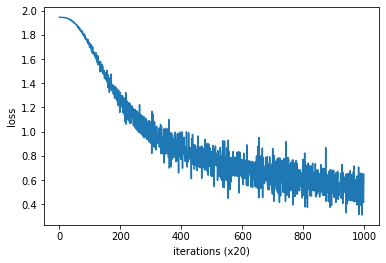

In [32]:
# coding: utf-8
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()




In [31]:
## 학습을 거듭할수록 손실이 줄어드는 것을 알 수 있다. 
## 학습이 끝난 후의 가중치 매개변수를 살펴보자

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [0.95075154 0.9513665  0.9582707  1.711654   1.2968011 ]
say [-1.1269794  -1.1562717  -1.1285212  -0.32065985  1.274437  ]
goodbye [ 1.0489203  1.039158   1.1037664 -0.8981842  0.4020832]
and [-0.80021346 -0.8795947  -0.84640056 -1.7842872   0.7732259 ]
i [ 1.042668    1.0625278   1.1116782  -0.8819372   0.39561424]
hello [0.9712453  0.945386   0.95394295 1.7009459  1.2788408 ]
. [-1.1456236 -1.138221  -1.1039761  1.6258106  1.3282353]


In [33]:
## word_vecs의 각 행에는 대응하는 단어 ID의 분산 표현이 저장되어있다.
## 이 밀집벡터가 바로 단어의 분산 표현이다.

# 5. word2vec 보충

In [35]:
## CBOW 모델을 확률의 관점에서 다시 살펴보자

### CBOW 모델과 확률

In [37]:
## 동시확률 P(A, B), 사후 확률 P(A | B)

In [38]:
##  CBOW 모델을 확률 표기법으로 기술해보자

## CBOW 모델이 하는 일은 맥락을 주면 타깃 단어가 출현할 확률을 출력하는 것
## 말뭉치를 w1, w2, ...., wt처럼 단어 시퀀스로 표기
## t번째 단어에 대해 윈도우 크기가 1인 맥락을 고려

In [39]:
## 맥락으로 w(t-1)과 w(t+1)이 주어졌을 때 타깃이 wt가 될 확률은 P(wt | w(t-1), w(t+1))
## w(t-1)과 w(t+1)이 일어난 후 wt가 일어날 확률을 의미
## 결국 CBOW는 위 식을 모델링하고 있는 것이다.

## 위 식을 이용하면 손실 함수도 간결하게 표현가능하다. 교차 엔트로피 오차를 적용하면
## L = -log( P(wt | w(t-1), w(t+1)))
## 이를 음의 로그 가능도(negative log likelihood)라 한다.
## 말뭉치 전체에 대한 손실함수로 확장하면 L = -1/T sum(log(P(wt | w(t-1), w(t+1))))

### Skip-gram 모델

In [42]:
## Skip-gram 모델은 CBOW에서 다루는 맥락과 타깃을 역전시킨 모델이다. 
## 타깃을 입력으로 받아 주변의 맥락을 추측한다.

## Skip-gram 모델의 입력층은 하나이다. 한편 출력층은 맥락의 수만큼 존재한다.
## 따라서 각 출력층에서는 개별적으로 손실을 구하고 모두 더한 값을 최종 손실로 한다.

## Skip-gram 모델을 확률로 나타내면 P(w(t-1), w(t+1) | wt) 이다. 
## 위 식의 의미는 wt가 주어졌을 때 w(t-1)과 w(t+1)이 동시에 일어날 확률을 의미한다.
## Skip-gram 모델에서는 맥락 단어들 사이에 관련성이 없다고 가정하고 다음과 같이 분해한다.( 조건부 독립)

In [43]:
## P(w(t-1), w(t+1) | wt) = P(w(t-1) | wt) * P(w(t+1) | wt)
## 교차 엔트로피 오차를 적용하여 손실함수 유도
## L = -logP(w(t-1), w(t+1) | wt)
##   = -logP(w(t-1) | wt)P(w(t+1) | wt)
##   = -(logP(w(t-1) | wt) + logP(w(t+1) | wt))

In [44]:
## L = -1/T sum(logP(w(t-1) | wt) + logP(w(t+1) | wt))

## Skip-gram 모델은 맥락의 수만큼 추측하기 때문에 그 손실 함수는 각 맥락에서 구한 손실의 총합이어야 한다.
## 반면 CBOW 모델은 타깃 하나의 손실을 구한다.

## 그럼 둘 중 어느 모델을 사용해야 할까?
## 단어 분산 표현의 정밀도 면에서 Skip-gram 모델의 결과가 더 좋은 경우가 많기 때문에 Skip-gram 모델을 사용해야한다. 
## 특히 말뭉치가 커질수록 더 뛰어난 성능을 내는 경향이 있다.
## 반면 학습 속도 면에서는 CBOW 모델이 더 빠르다. Skip-gram 모델은 손실을 맥락 수만큼 구해야 해서 계산 비용이 그만큼 커지기 때문

### 통계 기반 vs 추론 기반

In [45]:
## 지금까지 통계 기반 기법과 추론 기반 기법을 살펴보았다.

In [46]:
## 단어의 분산 표현을 갱신해야 하는 상황을 생각해보자

## 통계 기반에서는 계산을 처음부터 다시해야한다. 동시발생 행렬을 다시 만들고 SVD를 수행하는 작업을 다시 해야한다.
## 추론 기반은 매개변수를 다시 학습할 수 있다. 지금까지 학습한 가중치를 초기값으로 다시ㅏ 학습하면 된다.
## 이런 특성 덕분에 기존 학습한 경험을 해치지 않으면서 단어의 분산표현을 효율적으로 갱신가능하다.

In [47]:
## 단어의 분산 표현의 성격이나 정밀도 면에서는 어떨까?

## 통계 기반 기법에서는 주로 단어의 유사성이 인코딩 된다.
## 한편 word2vec에서는 단어의 유사성은 물론, 한층 더 복잡한 단어 사이의 패턴까지도 파악되어 인코딩 된다. 
## word2vec은 king - man + woman = queen 같은 유추문제를 풀 수 있다.
## 그러나 실제로 단어의 유사성을 정량평가해본 결과 의외로 추론과 통계 기반은 우열을 가릴 수 없다. 